# SpID Eval

I took lots of photos of cool spiders in Zimbabwe and neighboring countries. I figured they'd make a nice hard eval for multi-modal models! This notebook scrapes together 100 observations of mine and wraps them up in a nice huggingface dataset to use for future research. I also have several private versions (made in a similar fashion but different selection criteria) that I'll keep secret to avoid training data contamination.

In [1]:
# !pip install -qU requests datasets huggingface_hub tqdm

In [2]:
# from huggingface_hub import notebook_login
# notebook_login()

In [3]:
# inat request helpers
INAT_OBS_URL   = "https://api.inaturalist.org/v1/observations"
INAT_TAXA_URL  = "https://api.inaturalist.org/v1/taxa"

# project‑specific knobs
PLACE_ID       = 113055                   # “Southern Africa” on iNat
USER_ID        = "jonathan_whitaker"
RAW_TARGET     = 500                      # over‑collect because we’ll discard some
FINAL_TARGET   = 100
DISTRACTORS    = 4                        # 4 wrong + 1 correct  = 5‑choice MCQ

In [4]:
import requests, random, itertools, tqdm, time

def inat_observations(page=1, per_page=100):
    params = dict(user_id=USER_ID,
                  place_id=PLACE_ID,
                  per_page=per_page,
                  page=page,
                  quality_grade="research",   # only research‑grade
                  order_by="observed_on",
                  order="desc")
    return requests.get(INAT_OBS_URL, params=params, timeout=30).json()["results"]

def harvest_raw(n=RAW_TARGET):
    """Pull pages until we’ve got at least n usable obs."""
    good = []
    page  = 1
    while len(good) < n:
        for obs in inat_observations(page):
            taxon = obs.get("taxon") or {}
            if taxon.get("rank") != "species":          # skip higher‑level IDs
                continue
            if not obs.get("photos"):                   # need an image
                continue
            good.append(obs)
            if len(good) >= n: break
        page += 1
        time.sleep(0.2)                                # be polite
    return good[:n]

raw_obs = harvest_raw()
print(f"Collected {len(raw_obs)} candidate observations")

Collected 500 candidate observations


In [5]:
# raw_obs[0]

In [6]:
# raw_obs[0]['taxon']

In [7]:
def get_genera_in_family(family_id, exclude_id, k=DISTRACTORS):
    params = dict(rank='genus',
                  parent_id=family_id,
                  place_id=PLACE_ID,
                  per_page=50)
    genera = requests.get(INAT_TAXA_URL, params=params, timeout=30).json()["results"]
    pool = [gen for gen in genera if gen['id'] != exclude_id]
    picks = random.sample(pool, k=min(k, len(pool))) if pool else []
    return picks

def get_species_in_genus(genus_id, exclude_id, k=DISTRACTORS):
    params = dict(rank='species',
                  parent_id=genus_id,
                  place_id=PLACE_ID,
                  per_page=50)
    species = requests.get(INAT_TAXA_URL, params=params, timeout=30).json()["results"]
    pool = [sp for sp in species if sp['id'] != exclude_id]
    picks = random.sample(pool, k=min(k, len(pool))) if pool else []
    return [sp['name'] for sp in picks]

def get_species_in_family(family_id, exclude_id, k=DISTRACTORS):
    genera = get_genera_in_family(family_id, exclude_id)
    if not genera:
        return []  # Return an empty list if no genera are found
    chosen_species = []
    for genus in random.sample(genera, min(len(genera), k)):
        species = get_species_in_genus(genus['id'], exclude_id, k=1)
        if species:
            chosen_species.append(species[0])
    return chosen_species

# quick test on the first observation
first = raw_obs[0]
fam_id = first['taxon']['ancestor_ids'][-3]
get_species_in_family(fam_id,first['taxon']['id'])

['Augusta glyphica',
 'Gasteracantha falcicornis',
 'Afracantha camerunensis',
 'Gastroxya schoutedeni']

In [8]:
def observation_to_row(obs):
    taxon      = obs['taxon']
    correct    = taxon['name']
    family_id  = taxon['ancestor_ids'][-3]
    distractors = get_species_in_family(family_id, taxon['id'])
    options     = distractors + [correct]
    random.shuffle(options)
    answer_idx  = options.index(correct)

    # medium‑sized iNat URLs are built by swapping 'square' for 'medium' in the template
    photo_url   = obs['photos'][0]['url'].replace('square', 'medium')

    return dict(
        image = photo_url,
        options = options,
        answer = answer_idx,
        observation_id = obs['id']
    )

In [11]:
# prompt: Do this in a loop with tqdm and error handling, and only stop when FINAL_TARGET obs work
dataset_rows = []
with tqdm.tqdm(total=FINAL_TARGET) as pbar:
    for o in raw_obs:
        time.sleep(0.5) # TO be gentle on their API
        try:
            row = observation_to_row(o)
            # Filter out those without distractors
            if not row['options'] or len(row['options']) < 3: # I'll allow some with fewer options
                continue
            dataset_rows.append(row)
            pbar.update(1)
            if len(dataset_rows) == FINAL_TARGET:
                break  # Stop when FINAL_TARGET observations are processed
        except Exception as e:
            # print(f"Error processing observation: {e}")
            continue # Skip to the next observation if an error occurs
len(dataset_rows), dataset_rows[0]

100%|██████████| 100/100 [11:37<00:00,  6.97s/it]


(100,
 {'image': 'https://inaturalist-open-data.s3.amazonaws.com/photos/281357140/medium.jpeg',
  'options': ['Isoxya stuhlmanni',
   'Macracantha arcuata',
   'Actinacantha globulata',
   'Gasteracantha milvoides',
   'Parmatergus lens'],
  'answer': 0,
  'observation_id': 162709444})

In [12]:
from datasets import Dataset, Features, Value, Sequence, ClassLabel, Image

features = Features({
    "observation_id": Value("int32"),
    "image": Image(),
    "options": Sequence(Value("string")),
    "answer": Value("int32"),
})

ds = Dataset.from_list(dataset_rows, features=features)
ds = ds.shuffle(seed=42)   # optional
ds[0]                      # show one row

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
 'options': ['Trioceros rudis',
  'Nadzikambia mlanjensis',
  'Rieppeleon kerstenii',
  'Chamaeleo gracilis',
  'Rhampholeon marshalli'],
 'answer': 4,
 'observation_id': 112489466}

In [14]:
from huggingface_hub import HfApi
from google.colab import userdata


REPO_ID = "johnowhitaker/specid_eval_jw"
HF_TOKEN = userdata.get('hf_token')

# 1) create the repo once (skip if already exists)
HfApi(token=HF_TOKEN).create_repo(repo_id=REPO_ID, repo_type="dataset", private=False, exist_ok=True)

# 2) push
ds.push_to_hub(REPO_ID, token=HF_TOKEN)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/datasets/johnowhitaker/specid_eval_jw/commit/a58934a1b93e113d7a6756632ded7c4bf953c645', commit_message='Upload dataset', commit_description='', oid='a58934a1b93e113d7a6756632ded7c4bf953c645', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/johnowhitaker/specid_eval_jw', endpoint='https://huggingface.co', repo_type='dataset', repo_id='johnowhitaker/specid_eval_jw'), pr_revision=None, pr_num=None)

In [15]:
from datasets import load_dataset
demo = load_dataset(REPO_ID, split="train")
print(demo[0]["options"], " -> correct idx:", demo[0]["answer"])

README.md:   0%|          | 0.00/395 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/10.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

['Trioceros rudis', 'Nadzikambia mlanjensis', 'Rieppeleon kerstenii', 'Chamaeleo gracilis', 'Rhampholeon marshalli']  -> correct idx: 4


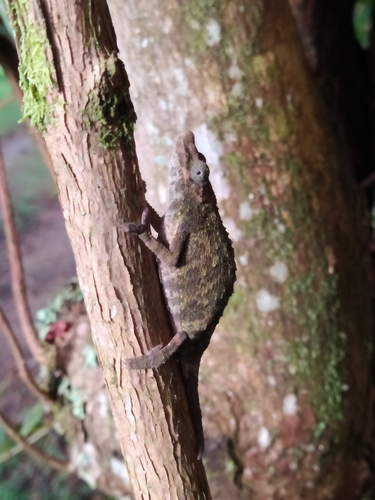

In [16]:
demo[0]["image"]